# Data Importing and Preprocessing


**_Data extraction_**


In [3]:
import csv
from selenium import webdriver
from selenium.webdriver.common.by import By
from selenium.webdriver.chrome.service import Service
from webdriver_manager.chrome import ChromeDriverManager
import time


driver = webdriver.Chrome(service=Service(ChromeDriverManager().install()))


url = "https://www.imdb.com/chart/top/"
driver.get(url)


time.sleep(5)


movie_elements = driver.find_elements(By.CSS_SELECTOR, "li.ipc-metadata-list-summary-item")

movies_data = []

for movie in movie_elements:
    try:
        title_element = movie.find_element(By.CSS_SELECTOR, "h3.ipc-title__text")
        title_text = title_element.text

        parts = title_text.split('. ', 1)
        title = parts[1] if len(parts) > 1 else title_text

       
        year_element = movie.find_element(By.CSS_SELECTOR, "span.cli-title-metadata-item")
        year = year_element.text

        rating_element = movie.find_element(By.CSS_SELECTOR, "span.ipc-rating-star")
        rating_text = rating_element.get_attribute("aria-label")
        rating = rating_text.split(': ')[1].split(' ')[0]

        movies_data.append({
            "title": title.strip(),
            "year": year.strip(),
            "rating": rating.strip()
        })
    except Exception as e:
        print(f"Error processing a movie: {e}")
        continue

driver.quit()


with open('imdb_top_250_movies.csv', mode='w', newline='', encoding='utf-8') as file:
    writer = csv.DictWriter(file, fieldnames=["title", "year", "rating"])
    writer.writeheader() 
    writer.writerows(movies_data)  

print(f"Total movies scraped: {len(movies_data)}")


Total movies scraped: 250


**_Data cleaning and regex_**


In [6]:
import pandas as pd


df = pd.read_csv("E:\\kolya projects\\tools project\\imdb_top_250_movies.csv")


df.duplicated().sum()
df.isnull().sum()

df_cleaned = df.copy()
df_cleaned['title_clean'] = df_cleaned['title'].str.replace(r"[^a-zA-Z0-9\s]", "", regex=True)
df_cleaned['sequel_info'] = df_cleaned['title'].str.extract(r"(Part\s+[IVX]+|\b\d{1,2}\b)")
df_cleaned['has_number'] = df_cleaned['title'].str.contains(r"\d", regex=True)
df_cleaned['title_clean'] = df_cleaned['title_clean'].str.replace(r"\s+", " ", regex=True).str.strip()
print(df_cleaned[['title', 'title_clean', 'sequel_info', 'has_number']].head(10))

df['title'] = df_cleaned['title_clean']
df_cleaned.drop(columns=['title_clean'], inplace=True)
print(df.head)

                                               title  \
0                           The Shawshank Redemption   
1                                      The Godfather   
2                                    The Dark Knight   
3                              The Godfather Part II   
4                                       12 Angry Men   
5      The Lord of the Rings: The Return of the King   
6                                   Schindler's List   
7                                       Pulp Fiction   
8  The Lord of the Rings: The Fellowship of the Ring   
9                     The Good, the Bad and the Ugly   

                                        title_clean sequel_info  has_number  
0                          The Shawshank Redemption         NaN       False  
1                                     The Godfather         NaN       False  
2                                   The Dark Knight         NaN       False  
3                             The Godfather Part II     Part II       F

**_Data analysis_**


In [7]:
from collections import Counter


rating_counts = df['rating'].value_counts().sort_index(ascending=False)
print("Number of movies by rating:")
print(rating_counts.head(10))  


top_years = df['year'].value_counts().sort_values(ascending=False)
print("Top 10 years with most Top 250 movies:")
print(top_years.head(10))


oldest = df[df['year'] == df['year'].min()]
newest = df[df['year'] == df['year'].max()]

print("Oldest movie(s) in the Top 250:")
print(oldest)

print("Newest movie(s) in the Top 250:")
print(newest)


highest_rating = df[df['rating'] == df['rating'].max()]
lowest_rating = df[df['rating'] == df['rating'].min()]

print("Highest rated movie(s):")
print(highest_rating)

print("Lowest rated movie(s):")
print(lowest_rating)


all_words = ' '.join(df['title']).lower().split()
word_counts = Counter(all_words)


stopwords = ['the', 'of', 'and', 'a', 'in', 'to']
filtered_words = {word: count for word, count in word_counts.items() if word not in stopwords}

sorted_words = sorted(filtered_words.items(), key=lambda x: x[1], reverse=True)
print("Most frequent words in movie titles:")
for word, count in sorted_words[:10]:
    print(f"{word}: {count}")


rating_by_year = df.groupby('year')['rating'].mean().sort_values(ascending=False)
print("Top 10 years by average movie rating:")
print(rating_by_year.head(10))







Number of movies by rating:
rating
9.3     1
9.2     1
9.0     5
8.9     2
8.8     7
8.7     6
8.6    12
8.5    25
8.4    24
8.3    41
Name: count, dtype: int64
Top 10 years with most Top 250 movies:
year
1995    8
2004    7
2003    6
1957    6
1999    6
2019    6
2009    6
1998    5
2010    5
2001    5
Name: count, dtype: int64
Oldest movie(s) in the Top 250:
       title  year  rating
137  The Kid  1921     8.2
Newest movie(s) in the Top 250:
              title  year  rating
55    Dune Part Two  2024     8.5
172  The Wild Robot  2024     8.2
200   Im Still Here  2024     8.3
215        Maharaja  2024     8.4
Highest rated movie(s):
                      title  year  rating
0  The Shawshank Redemption  1994     9.3
Lowest rated movie(s):
               title  year  rating
232  The Incredibles  2004     8.0
244    Into the Wild  2007     8.0
245    Groundhog Day  1993     8.0
248    Amores Perros  2000     8.0
Most frequent words in movie titles:
for: 6
wild: 4
part: 3
lord: 3
rings: 

**\***visualization**\***


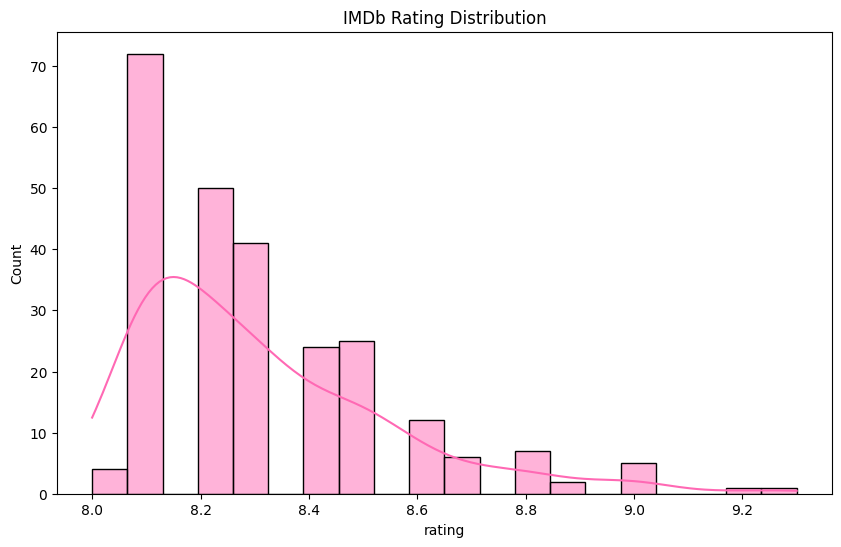

In [8]:
import matplotlib.pyplot as plt
import seaborn as sns

fig, ax = plt.subplots(figsize=(10, 6))
sns.histplot(df_cleaned['rating'], bins=20, kde=True, color='hotpink', ax=ax)
ax.set_title('IMDb Rating Distribution')
plt.show()

C:\Users\Dell\AppData\Local\Temp\ipykernel_6704\153769204.py:5: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels(ax.get_xticklabels(), rotation=90)


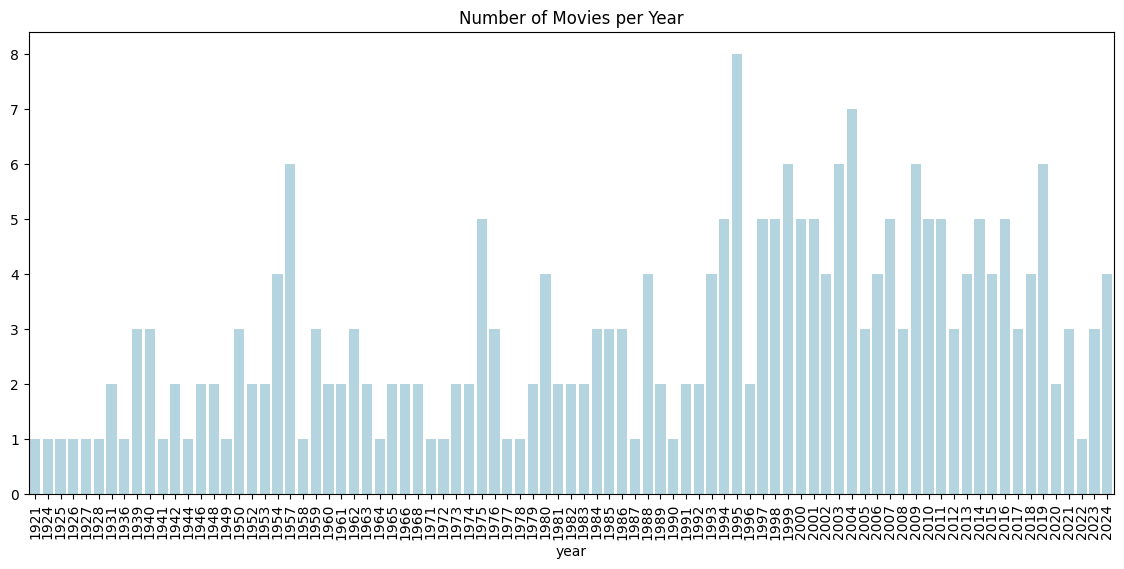

In [9]:
year_counts = df_cleaned['year'].value_counts().sort_index()
fig, ax = plt.subplots(figsize=(14, 6))
sns.barplot(x=year_counts.index, y=year_counts.values, color='lightblue', ax=ax)
ax.set_title('Number of Movies per Year')
ax.set_xticklabels(ax.get_xticklabels(), rotation=90)
plt.show()

C:\Users\Dell\AppData\Local\Temp\ipykernel_6704\3784433242.py:3: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x='rating', y='title', data=top_10, palette='magma', ax=ax)


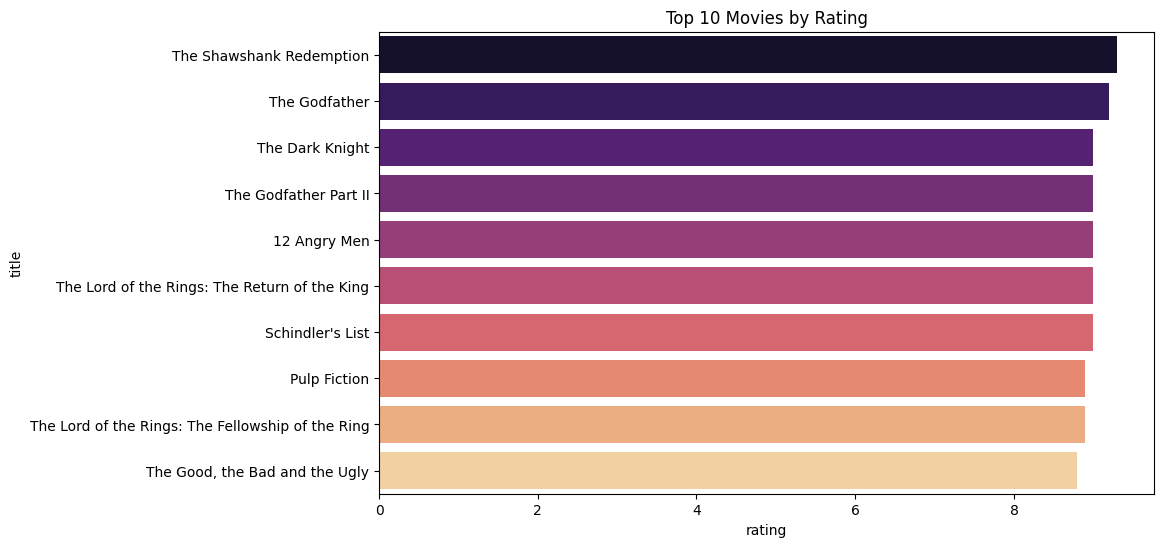

In [10]:
top_10 = df_cleaned.sort_values(by='rating', ascending=False).head(10)
fig, ax = plt.subplots(figsize=(10, 6))
sns.barplot(x='rating', y='title', data=top_10, palette='magma', ax=ax)
ax.set_title('Top 10 Movies by Rating')
plt.show()

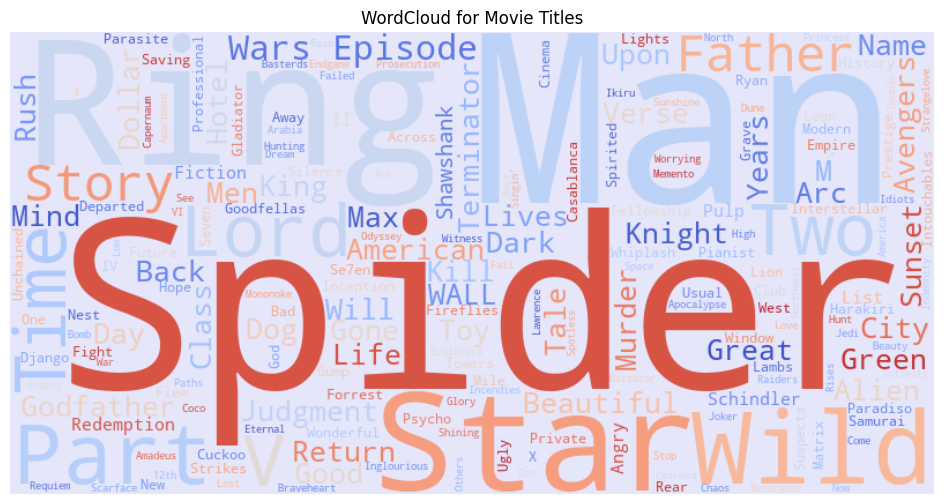

In [11]:
from wordcloud import WordCloud

text = ' '.join(df_cleaned['title'])
wordcloud = WordCloud(width=800, height=400, background_color='lavender', colormap='coolwarm').generate(text)

plt.figure(figsize=(12, 6))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off')
plt.title('WordCloud for Movie Titles')
plt.show()

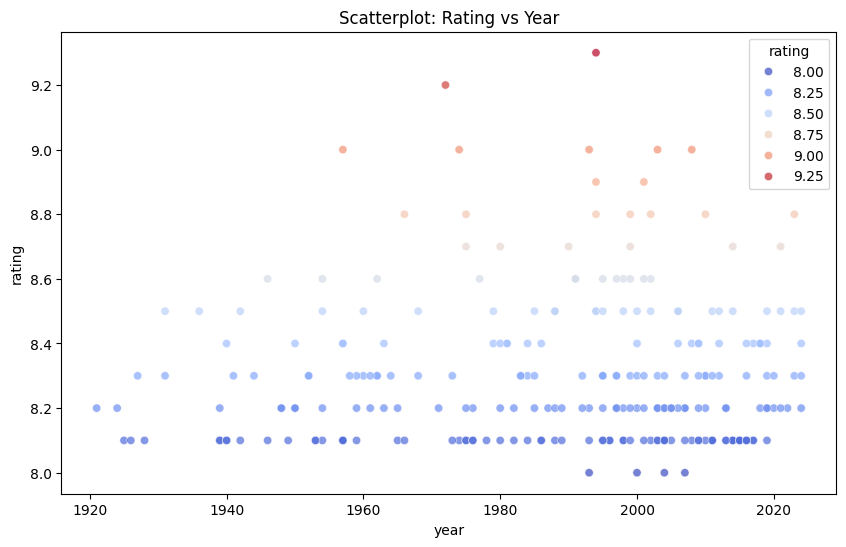

In [12]:
fig, ax = plt.subplots(figsize=(10, 6))
sns.scatterplot(data=df_cleaned, x='year', y='rating', alpha=0.7, hue='rating', palette='coolwarm', ax=ax)
ax.set_title('Scatterplot: Rating vs Year')
plt.show()

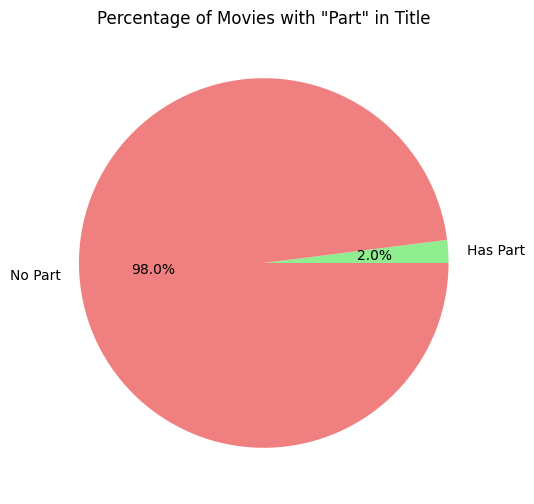

In [13]:
part_movies = df_cleaned['title'].str.contains('Part', case=False).sum()
total_movies = len(df_cleaned)

fig, ax = plt.subplots(figsize=(6, 6))
plt.pie(
    [part_movies, total_movies - part_movies],
    labels=['Has Part', 'No Part'],
    autopct='%1.1f%%',
    colors=['lightgreen', 'lightcoral']
)
ax.set_title('Percentage of Movies with "Part" in Title')
plt.show()